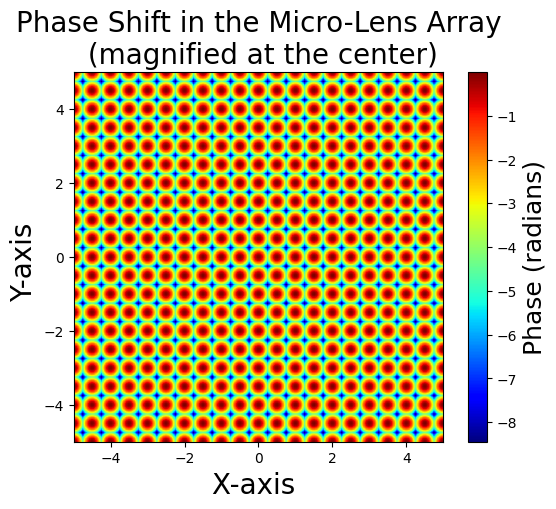

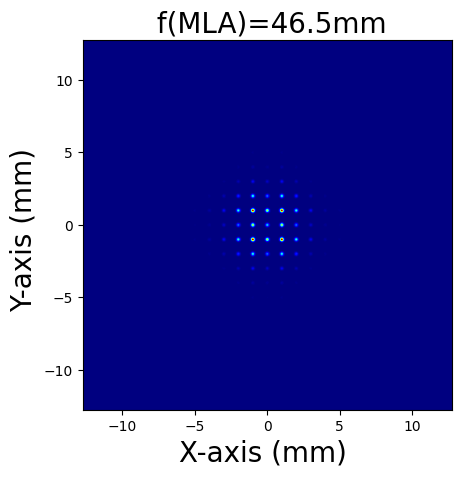

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Manually assign a name since __file__ is not available in Jupyter
file = 'Microlensarray'  # You can change this as needed
File = os.path.splitext(file)[0]

# def files--------------

# angular spectrum
def angular_spectrum_method_with_padding_zarray(field, z_arr, wavelength, dx, dy, pad_width, alpha, bandwidth_limit=True):
    """
    Angular Spectrum Method with Padding and Bandwidth Limiting.
    """
    k = 2 * np.pi / wavelength  # Wave number

    # Padding the input field
    padded_field = np.pad(field, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')

    # Creating an absorption mask
    Nx, Ny = padded_field.shape
    x = np.linspace(-1, 1, Nx)
    y = np.linspace(-1, 1, Ny)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    absorption_mask = np.exp(-alpha * np.maximum(r - 1 + 2 * pad_width / max(Nx, Ny), np.zeros_like(r))**2)

    # Applying the absorption mask
    padded_field *= absorption_mask

    # Fourier Transform of the input field
    field_ft = np.fft.fft2(padded_field)

    # Spatial frequencies
    kx = np.fft.fftfreq(Nx, dx) * 2 * np.pi
    ky = np.fft.fftfreq(Ny, dy) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky, indexing="ij")

    # Bandwidth limiting
    if bandwidth_limit:
        k_max = k
        mask = (kx**2 + ky**2 <= k_max**2)
        field_ft *= mask

    # kz in the frequency domain
    kz = np.sqrt(np.clip(k**2 - kx**2 - ky**2, 0, None))

    propagated_fields = np.empty((len(z_arr), field.shape[0], field.shape[1]), dtype=np.complex128)
    for count, z in enumerate(z_arr):    # Looping over z
        # Propagation phase factor
        phase_factor = np.exp(1j * kz * z)

        # Propagated field in the frequency domain
        propagated_field_ft = field_ft * phase_factor

        # Inverse Fourier Transform to get the field at distance z
        propagated_field = np.fft.ifft2(propagated_field_ft)

        # Removing padding
        propagated_field = propagated_field[pad_width:Nx-pad_width, pad_width:Ny-pad_width]
        propagated_fields[count, :, :] = propagated_field

    return propagated_fields


# Micro_lense_array

# Fourier lens
def fourier_lens(X, Y, f, wavelength):
    #phase =np.pi/(wavelength * f) * np.exp(-(X**2 + Y**2)/70e-3**2)
    phase =  -np.pi / (wavelength * f) * (X**2 + Y**2)

    return phase # np.pi / (wavelength * f) * (X**2 + Y**2)
# Parabolic phase function for a single lens
def parabolic_phase(X, Y, f, wavelength):
    #phase =np.pi/(wavelength * f) * np.exp(-(X**2 + Y**2)/70e-3**2)
    phase =  -np.pi / (wavelength * f) * (X**2 + Y**2)

    return phase # np.pi / (wavelength * f) * (X**2 + Y**2)

# Loop over each lens position in the array
def micro_lens_array(num_lenses, lens_diameter, single_grid, grid_size_per_lens, focal_length, wavelength,x0):
    # Total grid size for the array
    total_grid_size = grid_size_per_lens * num_lenses

    # Initialize the grid for the entire array
    phase_shift_array = np.zeros((total_grid_size, total_grid_size))
    # Loop over each lens position in the array
    count=0
    for i in range(num_lenses):
        for j in range(num_lenses):
            count=count+1
            # Calculate the offset for each lens
            x_offset = (i - num_lenses // num_lenses) * lens_diameter
            y_offset = (j - num_lenses // num_lenses) * lens_diameter

            # Create grid for a single lens
            #x = np.linspace(y_offset, y_offset + lens_diameter / (num_lenses/2), grid_size_per_lens)
            x = np.linspace(-single_grid/2, single_grid/2, grid_size_per_lens)+x0
            y = np.linspace(-single_grid/2, single_grid/2, grid_size_per_lens)+x0
            X, Y = np.meshgrid(x, y)
            #print([x[0], x[-1], i], [y[0], y[-1], j])
            #print([y[0], y[-1], i])

            # Calculate and insert the phase shift for this lens into the array
            phase_shift = parabolic_phase(X, Y, focal_length, wavelength) 
            #plt.subplot(num_lenses,num_lenses,count)
            #plt.pcolormesh(x,y,phase_shift)

            start_idx_x = i * grid_size_per_lens
            start_idx_y = j * grid_size_per_lens
            phase_shift_array[start_idx_x:start_idx_x + grid_size_per_lens, start_idx_y:start_idx_y + grid_size_per_lens] = phase_shift
    return phase_shift_array


def propagation_phase_element(field, phase_shift, z_array,wavelength, dx, dy, pad_width, alpha,xx,yy, filename):
    fieldn = field*np.exp(1j*phase_shift)
    output_field = angular_spectrum_method_with_padding_zarray(fieldn, z_array, wavelength, dx, dy, pad_width, alpha, bandwidth_limit=True)
    z_size = np.shape(z_array)[0]
    plt.figure()
    for ii in range(0,z_size):
        plt.subplot(1,z_size,ii+1)
        plt.pcolormesh(xx,yy,np.abs(output_field[ii,:,:])*2,cmap='jet')
        plt.title(f"z = {z_array[ii]} (mm)", fontsize=20)
        plt.gca().set_aspect('equal', adjustable='box')
    FileFig = filename + 'Fieldtrans_focallength' + str(focal_length)+'wb'+ str(wb) + 'FL' + str(focal_lengthFL) + '_nlenses' +str(num_lenses) +'.png'
    plt.savefig(FileFig)
    plt.close('all')
    
    return output_field

#####--------------------------------------------------------------------------------------------------

# Parameters all in millimeters
focal_length = 46.5 #5.6 #14.2 #8 #5.6  # mm
#focal_lengthp = 46.5 #7 #  8,7, 6, 2.5  shifted position of the second MLA 7 gives equal for wb 0.3
focal_lengthFL = 500#200    # of the Fourier Lens
wavelength = 1e-3  # 1.03e-3 mm (example wavelength)

grid_size_per_lens = 50  # 50 150 Number of cells across a lens diameter
num_lenses = 51#25# 25 # 5x5 array
single_grid = 500e-3 #300e-3 # in mm  150um
lens_diameter = single_grid*num_lenses  # mm (total size of MLA)

wb = 0.94 #0.5 #120e-3

# Total grid size for the array
total_grid_size = grid_size_per_lens * num_lenses

## Initialize the grid for the entire array
#phase_shift_array = np.zeros((total_grid_size, total_grid_size))


# Visualize the phase shift for the entire array
xx = np.linspace(-lens_diameter/2, lens_diameter/2, total_grid_size)
yy = np.linspace(-lens_diameter/2, lens_diameter/2, total_grid_size)
XX, YY = np.meshgrid(xx, yy)
#focal_length = 5.6 #5.6 # in mm of t he micro lens array

#z_arr = np.linspace(0,focal_lengthFL,100)

pad_width = 140  # Padding width
alpha = 16  # Absorption coefficient
dx = xx[1]-xx[0]
dy = dx

field = num_lenses*np.exp(-(XX**2 + YY**2)/wb**2)
phase_shift_array = micro_lens_array(num_lenses, lens_diameter, single_grid, grid_size_per_lens, focal_length, wavelength,0)

z_arr = np.array([0, 1, focal_lengthFL])
# propagation through the first MLA --> FL
output_MLA1 = propagation_phase_element(field, phase_shift_array, z_arr,wavelength, dx, dy, pad_width, alpha,xx,yy, File + 'output_MLA1') 

# Plot the phase shift of the micro-lens array (MLA)
# zoomed picture of the <mla phase shift
plt.figure()
mesh=plt.pcolormesh(xx, yy, phase_shift_array, cmap='jet')
cbar=plt.colorbar(mesh, label="Phase (radians)")  # Add color bar with label
cbar.set_label('Phase (radians)', fontsize=18)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Phase Shift in the Micro-Lens Array\n (magnified at the center)", fontsize=20)

# Set x and y axis limits
plt.xlim(-5, 5)
plt.ylim(-5, 5)
# Add x and y axis labels
plt.xlabel('X-axis ', fontsize=20)
plt.ylabel('Y-axis ', fontsize=20)

FileFig = File + 'Phase_Shift_in_MLA' + '_nlenses' + str(num_lenses) + '.png'
plt.savefig(FileFig)
plt.show()


#Plotting image in FL image plane
plt.figure()
plt.pcolormesh(xx,yy,np.abs(output_MLA1[0,:,:])**2, cmap ='jet') # is the field after MLA1
plt.gca().set_aspect('equal', adjustable='box')
FileFig = File + 'INPUT_wvl' + str(wavelength/1e-3) +'wb'+ str(wb) + 'FL' + str(focal_lengthFL) + '_nlenses' +str(num_lenses) +'.png'
plt.savefig(FileFig)

# propagation through the FL1 --> image plane --> FL2
fourier_lens_phase = fourier_lens(XX,YY,focal_lengthFL,wavelength)

z_arr = np.array([0, focal_lengthFL, 2*focal_lengthFL])
output_FL1 = propagation_phase_element(output_MLA1[-1,:,:], fourier_lens_phase, z_arr,wavelength, dx, dy, pad_width, alpha,xx,yy, File + 'output_FL1') # propagation until the FL2

# Plot the image at the focal plane of the Fourier lens (focus)

plt.figure()
plt.pcolormesh(xx, yy, np.abs(output_FL1[1, :, :])**2, cmap='jet')  # Use intensity (|field|^2)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f" f(MLA)=46.5mm", fontsize=20)
# Add x and y axis labels
plt.xlabel('X-axis (mm) ', fontsize=20)
plt.ylabel('Y-axis (mm) ', fontsize=20)
FileFig = File + 'Image_at_Fourier_focal_plane_FL' + str(focal_lengthFL) + '_nlenses' + str(num_lenses) + '.png'
plt.savefig(FileFig)
plt.show()
